In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")

In [4]:
train_data.isnull().sum() * 100 / len(train_data)

id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                     

# EDA and Data Cleaning

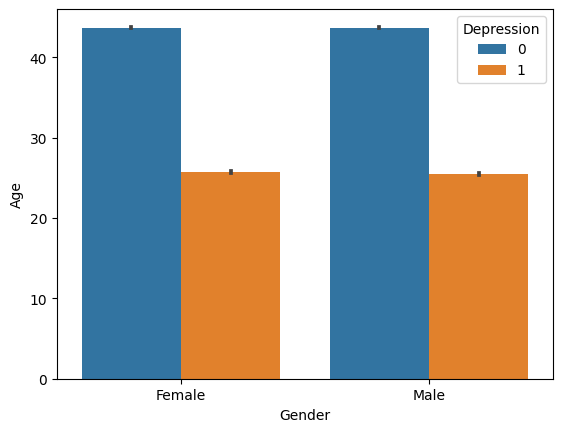

In [5]:
sns.barplot(data = train_data, x = 'Gender', y = 'Age',hue='Depression')
plt.show()

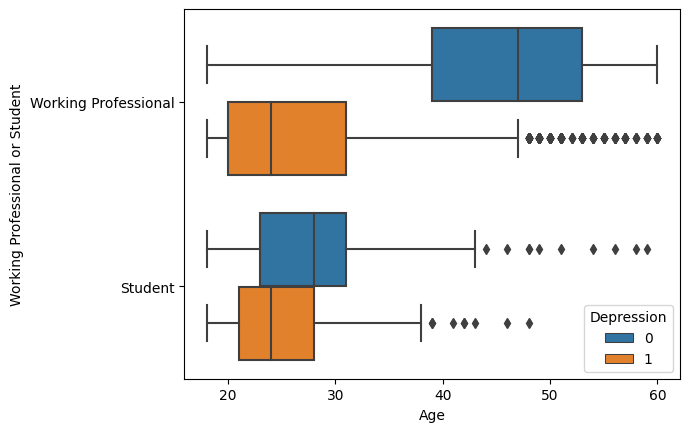

In [6]:
sns.boxplot(x='Age',hue='Depression',data=train_data,y='Working Professional or Student')
plt.show()

In [7]:
train_data['Profession'].unique()

array(['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst',
       'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
       'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
       'HR Manager', 'UX/UI Designer', 'Content Writer',
       'Educational Consultant', 'Civil Engineer', 'Manager',
       'Pharmacist', 'Financial Analyst', 'Architect',
       'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
       'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
       'Digital Marketer', 'Lawyer', 'Research Analyst',
       'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
       'Family Consultant', 'B.Com', 'BE', 'Student', 'Yogesh', 'Dev',
       'MBA', 'LLM', 'BCA', 'Academic', 'Profession', 'FamilyVirar',
       'City Manager', 'BBA', 'Medical Doctor', 'Working Professional',
       'MBBS', 'Patna', 'Unveil', 'B.Ed', 'Nagpur', 'Moderate', 'M.Ed',
       'Analyst', 'Pranav', 'Visakhapatnam', 'PhD', 'Yu

In [8]:
Profession = ['Chef', 'Teacher', 'Business Analyst', 'Financial Analyst',
       'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
       'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
       'HR Manager', 'UX/UI Designer', 'Content Writer',
       'Educational Consultant', 'Civil Engineer', 'Manager',
       'Pharmacist', 'Architect',
       'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
       'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
       'Digital Marketer', 'Lawyer', 'Research Analyst',
       'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
       'Family Consultant','Student','Academic', 'Profession', 'FamilyVirar',
       'City Manager', 'BBA', 'Medical Doctor', 'Working Professional',
       'Analyst']

train_data['Profession'] = train_data['Profession'].apply(lambda x: x if x in Profession else 'unknown')

In [9]:
train_data['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

In [10]:
sleep_timings= {'Less than 5 hours': 'Less than 5 hours',
    '5-6 hours': 'Less than 5 hours',
    '6-7 hours': 'More than 8 hours',
    '7-8 hours': 'More than 8 hours',
    '8-9 hours': 'More than 8 hours',  # Combining close ranges
    '9-11 hours': 'More than 8 hours',
    '10-11 hours': 'More than 8 hours',
    'More than 8 hours': 'More than 8 hours',
    '3-4 hours': 'Less than 5 hours',
    '2-3 hours': 'Less than 5 hours',
    '4-5 hours': 'Less than 5 hours',
    '6-8 hours': 'More than 8 hours',
    '1-6 hours': 'Less than 5 hours',
    'No': 'Less than 5 hours',  # Mapping 'No' to a category
    'Sleep_Duration': 'Less than 5 hours',  # Handling invalid entries
    'Unhealthy': 'Less than 5 hours',  # Handling invalid entries
    '45': 'Less than 5 hours',  # Handling invalid numerical values
    'than 5 hours': 'Less than 5 hours',
    'Work_Study_Hours': 'Less than 5 hours',  # Handling invalid entries
    'Pune': 'Less than 5 hours',  # Handling invalid entries
    '9-5': 'More than 8 hours',  # Normalizing to a reasonable category
    '45-48 hours': 'More than 8 hours',  # Handling invalid ranges
    '3-6 hours': 'Less than 5 hours',  # Grouping similar values
    '49 hours': 'More than 8 hours',  # Handling invalid values
    'Moderate': 'More than 8 hours',  # Handling invalid entries
    '40-45 hours': 'More than 8 hours',  # Handling invalid ranges
    '1-2 hours': 'Less than 5 hours',
    '9-5 hours': 'More than 8 hours',  # Normalizing to a reasonable category
    '55-66 hours': 'More than 8 hours',  # Handling invalid ranges
    'Indore': 'Less than 5 hours',  # Handling invalid entries
    '35-36 hours': 'More than 8 hours',  # Handling invalid ranges
    '1-3 hours': 'Less than 5 hours',  # Grouping similar values
}

train_data['Sleep Duration'] = train_data['Sleep Duration'].map(sleep_timings).fillna('Unknown')


In [11]:
train_data['Dietary Habits'].value_counts()

Dietary Habits
Moderate             49705
Unhealthy            46227
Healthy              44741
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64

In [12]:
health_status_mapping = {
    'Moderate': 'Moderate',
    'Unhealthy': 'Unhealthy',
    'Healthy': 'Healthy',
    'More Healthy': 'Healthy',  # Mapping similar categories
    'Less Healthy': 'Unhealthy',  # Mapping similar categories
    'Less than Healthy': 'Unhealthy',  # Mapping similar categories
    'Yes': 'Healthy',
    'No': 'Unhealthy',
    'No Healthy': 'Unhealthy',
    'Class 12': 'Unknown',
    'Indoor': 'Unknown',
    'Male': 'Unknown',
    'Vegas': 'Unknown',
    'M.Tech': 'Unknown',
    '1.0': 'Unknown',
    'Electrician': 'Unknown',
    'Hormonal': 'Unknown',
    'Mihir': 'Unknown',
    '3': 'Unknown',
    'Gender': 'Unknown',
    'BSc': 'Unknown',
    'Pratham': 'Unknown',
    '2': 'Unknown'
}

# Apply the mapping to the 'Health Status' column
train_data['Dietary Habits'] = train_data['Dietary Habits'].map(health_status_mapping).fillna('Unknown')


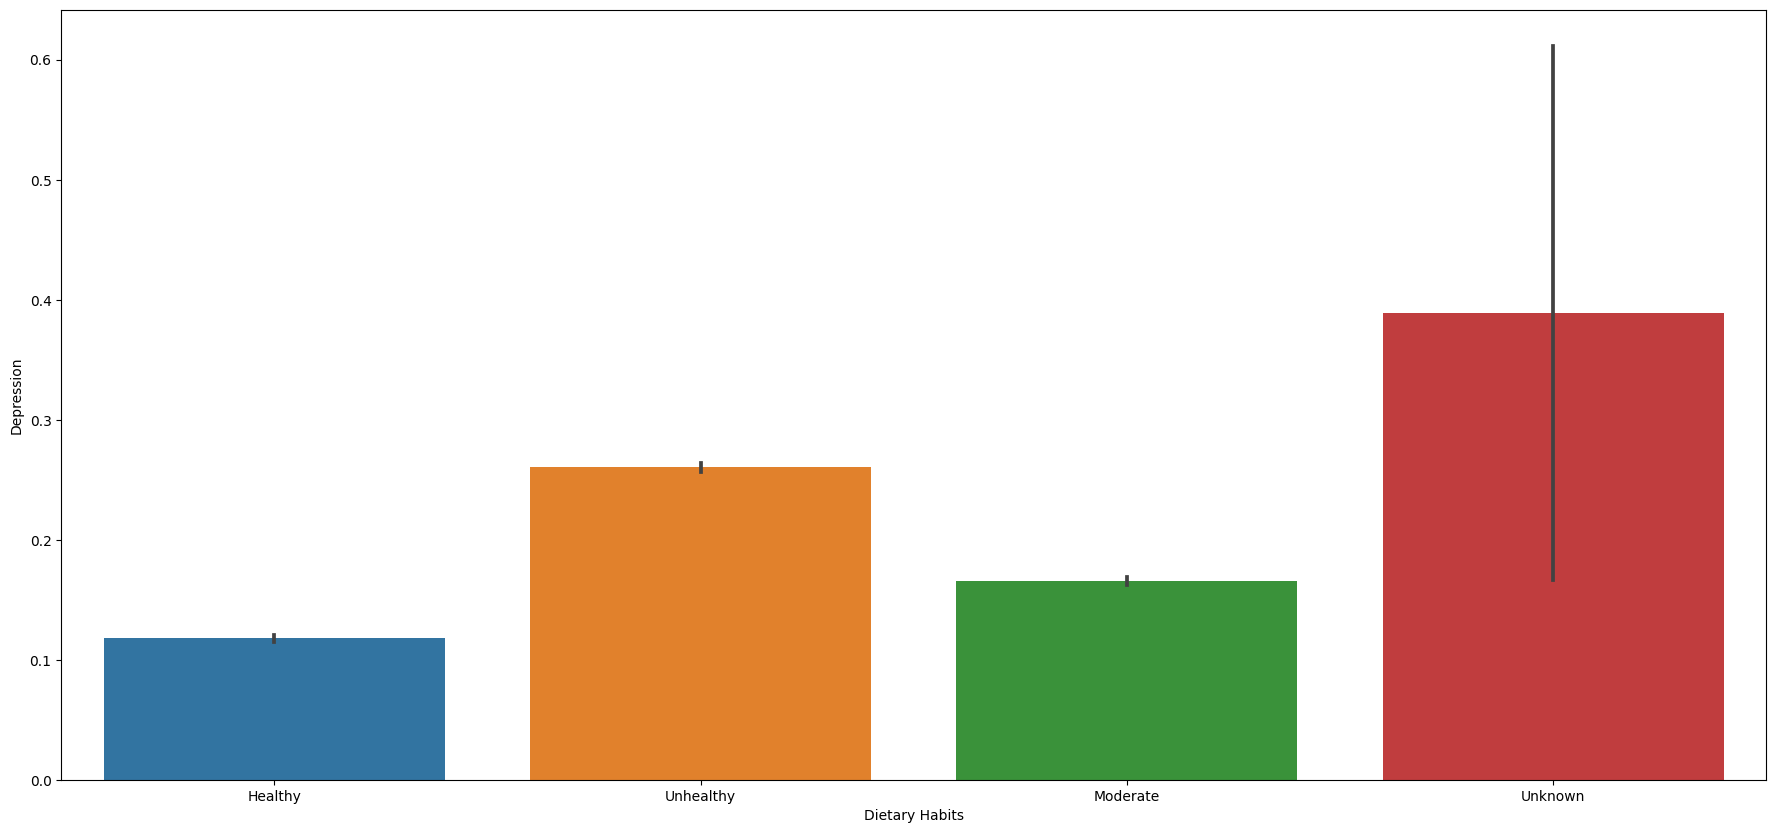

In [13]:
plt.figure(figsize =[22,10])
sns.barplot(data = train_data, x= 'Dietary Habits', y= 'Depression')
plt.show()

In [14]:
Degree = ['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'BSc', 'ME', 'B.Arch',
       'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', 'MHM', 'BA',
       'M.Tech', 'PhD', 'M.Ed', 'MSc', 'B.Tech', 'LLM',
       'MBBS', 'M.Pharm', 'MPA', 'BH',  'BEd',
       'B.Sc', 'S.Tech', 'Degree' 'Class 11',
       'H_Pharm', 'P.Com', 'BPharm', 'M.Arch',
       'LL.Com', 'MPharm', 'L.Ed', 'P.Pharm', 
       'BArch', 'S.Pharm', 'LLBA',
         'LLCom', 
       'MTech', 'BPA',
        'MEd', 'B.BA', 'B.B.Arch', 'ACA',
        'M_Tech', 
       'LLTech',  'LHM', 'S.Arch',
        'HCA',  'LL B.Ed', 'M.S', 
         'K.Ed',
        'LLS', 'LLEd', 'E.Tech', 'N.Pharm',
       'B B.Com']

In [15]:
# Convert the Degree list to a set for faster lookup
degree_set = set(Degree)

# Standardize the Degree column
train_data.loc[:, 'Degree'] = train_data['Degree'].apply(lambda x: x if x in degree_set else 'unknown')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


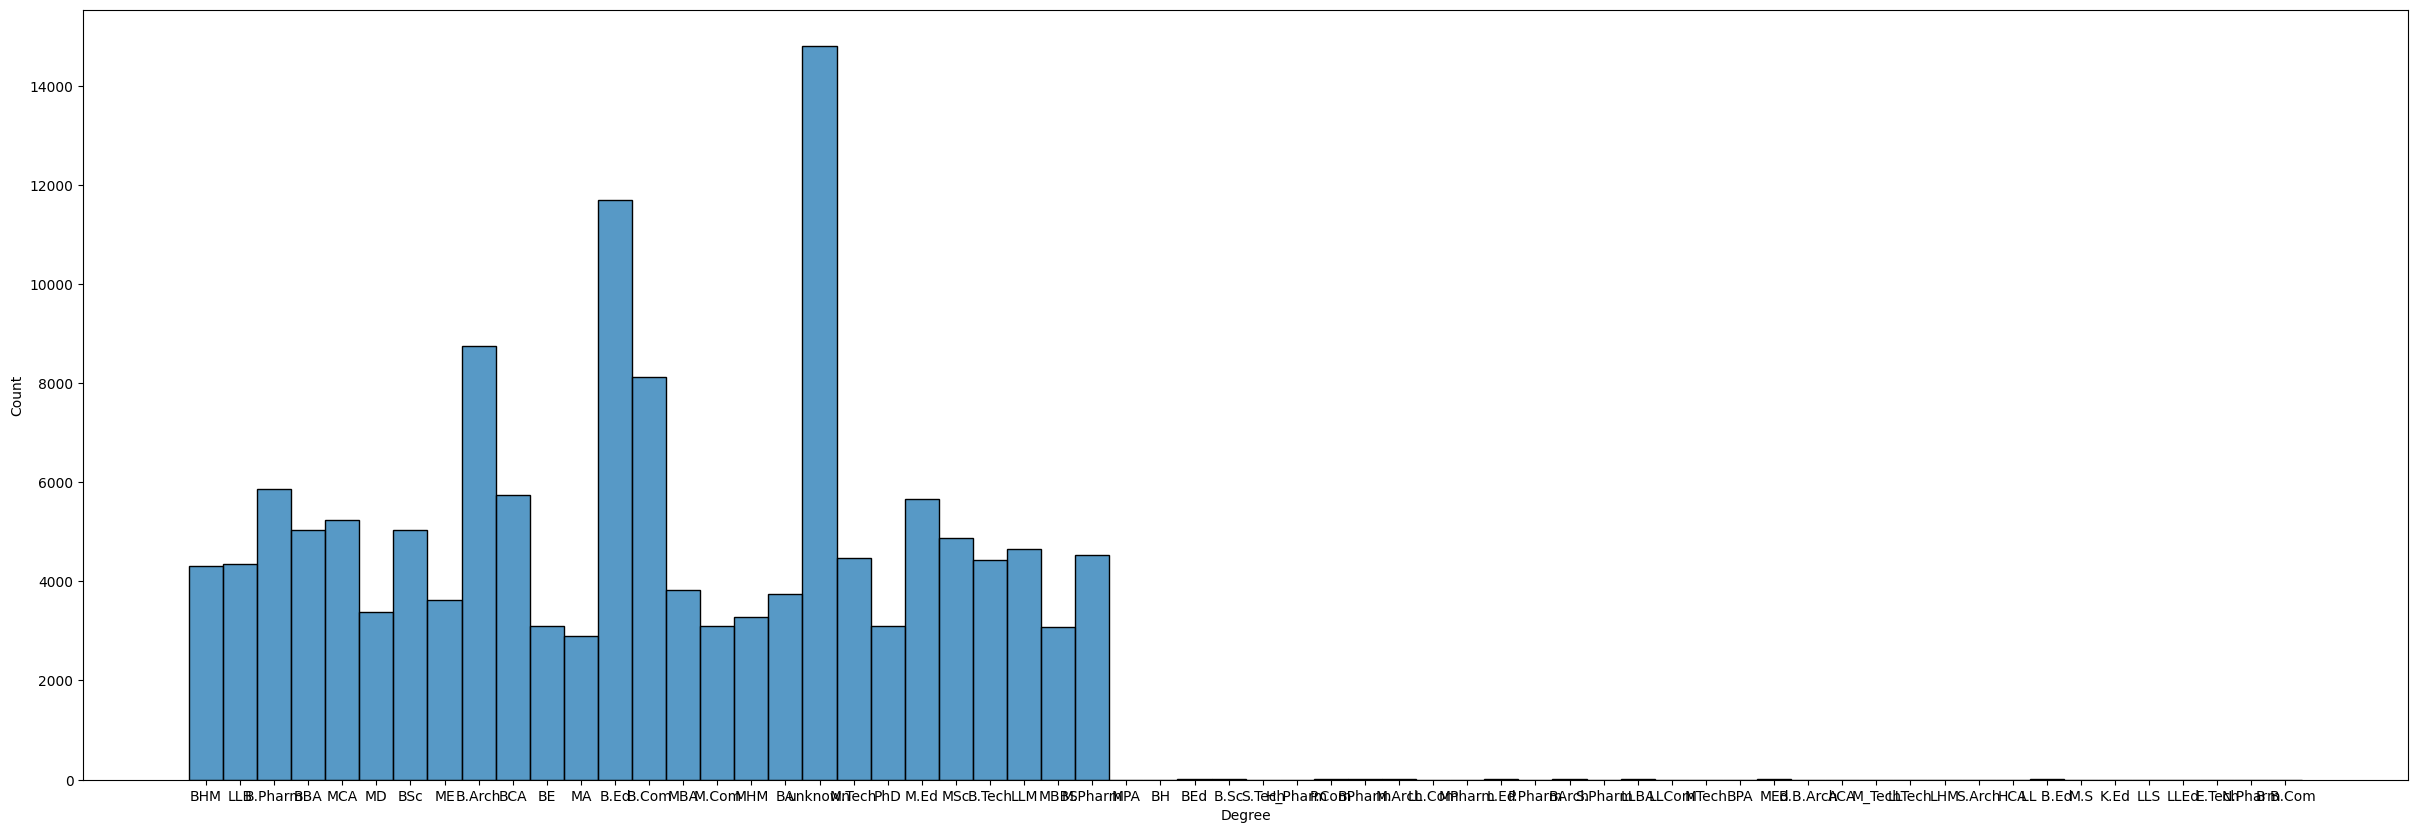

In [16]:
plt.figure(figsize =[30,10])
sns.histplot(data = train_data, x= 'Degree')
plt.show()

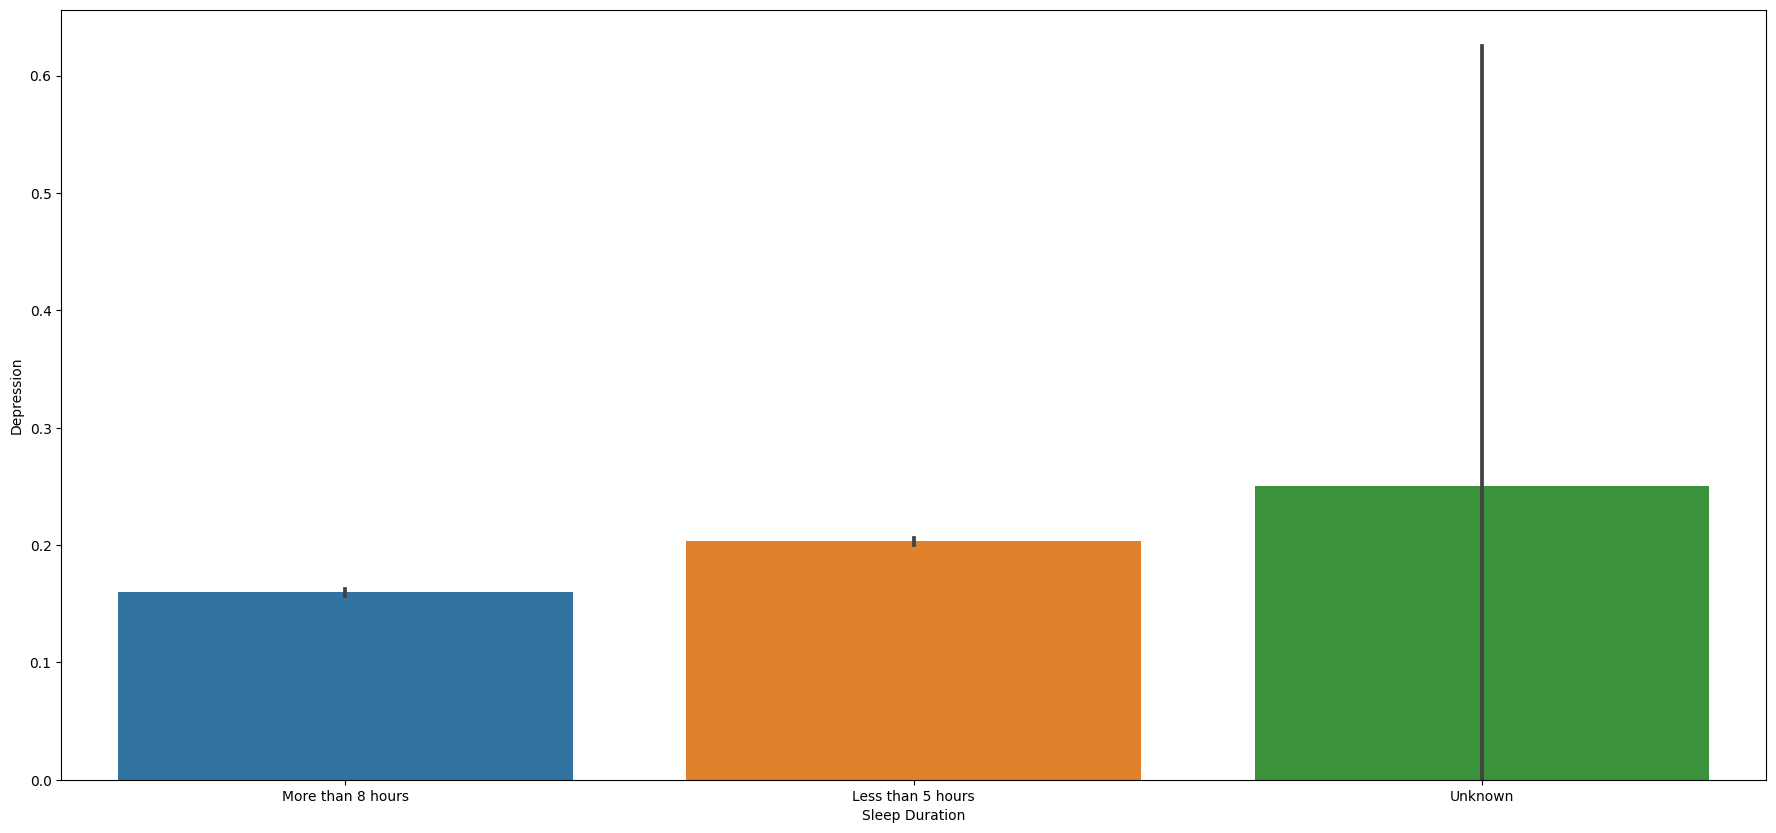

In [17]:
plt.figure(figsize =[22,10])
sns.barplot(data = train_data, x= 'Sleep Duration', y= 'Depression')
plt.show()

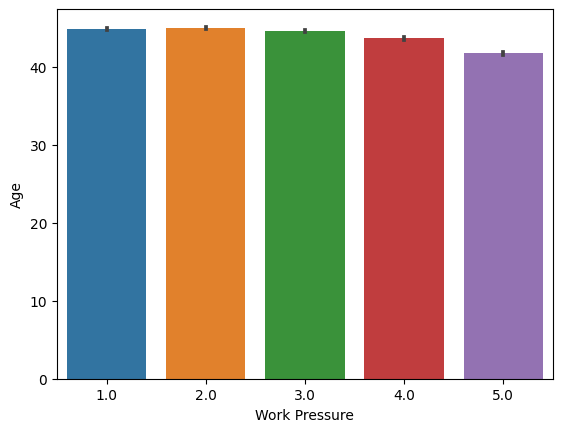

In [18]:
sns.barplot(data = train_data, x= 'Work Pressure', y = 'Age')
plt.show()

In [19]:
categorical_cols = ['Name','Gender','City','Working Professional or Student','Profession','Academic Pressure','Work Pressure','Study Satisfaction','Job Satisfaction','Sleep Duration','Dietary Habits','Degree','Have you ever had suicidal thoughts ?','Financial Stress','Family History of Mental Illness']

In [20]:
train_data['Academic Pressure'].value_counts()

Academic Pressure
3.0    7463
5.0    6296
4.0    5158
1.0    4801
2.0    4179
Name: count, dtype: int64

# Fill Data with approximate values

In [21]:
train_data.loc[
    (train_data['Academic Pressure'].isnull()) & 
    (train_data['Working Professional or Student'] == 'Working Professional') & 
    (train_data['Degree'].isnull()),
    'Academic Pressure'
] = 0

train_data.loc[
    (train_data['Academic Pressure'].isnull()) & 
    (train_data['Working Professional or Student'] == 'Student') & 
    (train_data['Degree'].isnull()),
    'Academic Pressure'
] = 0

train_data.loc[train_data['Academic Pressure'].isnull(), 'Academic Pressure'] = np.random.randint(0, 6, size=train_data['Academic Pressure'].isnull().sum())

In [22]:
train_data.loc[
    (train_data['Work Pressure'].isnull()) & 
    (train_data['Working Professional or Student'] == 'Student'),
    'Work Pressure'
] = 0

train_data.loc[train_data['Work Pressure'].isnull(), 'Work Pressure'] = np.random.randint(0, 6, size=train_data['Work Pressure'].isnull().sum())

In [23]:
train_data.loc[
    (train_data['Study Satisfaction'].isnull()) & 
    (train_data['Working Professional or Student'] == 'Working Professional'),
    'Study Satisfaction'
] = 0

train_data.loc[train_data['Study Satisfaction'].isnull(), 'Study Satisfaction'] = np.random.randint(0, 6, size=train_data['Study Satisfaction'].isnull().sum())

In [24]:
train_data.loc[
    (train_data['Job Satisfaction'].isnull()) & 
    (train_data['Working Professional or Student'] == 'Student'),
    'Job Satisfaction'
] = 0

train_data.loc[train_data['Job Satisfaction'].isnull(), 'Job Satisfaction'] = np.random.randint(0, 6, size=train_data['Job Satisfaction'].isnull().sum())

In [25]:
train_data.loc[
    (train_data['CGPA'].isnull()) & 
    (train_data['Working Professional or Student'] == 'Student') & (train_data['Degree'].isnull()),
    'CGPA'
] = 0

train_data.loc[train_data['CGPA'].isnull(), 'CGPA'] = np.random.randint(0, 9, size=train_data['CGPA'].isnull().sum())

In [26]:
train_data = train_data.dropna(subset = ['Financial Stress'],axis=0)

In [27]:
train_data.isnull().sum() # check all null values are gone or not

id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [28]:
test_data.isnull().sum() 

id                                           0
Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               24632
Academic Pressure                        75033
Work Pressure                            18778
CGPA                                     75034
Study Satisfaction                       75033
Job Satisfaction                         18774
Sleep Duration                               0
Dietary Habits                               5
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
dtype: int64

In [29]:
test_data['Profession'] = test_data['Profession'].apply(lambda x : x if x in Profession else 'unknown')

In [30]:
test_data['Sleep Duration'] = test_data['Sleep Duration'].map(sleep_timings).fillna('unknown')

In [31]:
test_data['Dietary Habits'] = test_data['Dietary Habits'].map(health_status_mapping).fillna('unknown')

In [32]:
test_data['Degree'] = test_data['Degree'].apply(lambda x: x if x in Degree else 'unknown')

In [33]:
test_data.loc[
    (test_data['Academic Pressure'].isnull()) & 
    (test_data['Working Professional or Student'] == 'Working Professional') & 
    (test_data['Degree'].isnull()),
    'Academic Pressure'
] = 0

test_data.loc[
    (test_data['Academic Pressure'].isnull()) & 
    (test_data['Working Professional or Student'] == 'Student') & 
    (test_data['Degree'].isnull()),
    'Academic Pressure'
] = 0

test_data.loc[test_data['Academic Pressure'].isnull(), 'Academic Pressure'] = np.random.randint(0, 6, size=test_data['Academic Pressure'].isnull().sum())




In [34]:
test_data.loc[
    (test_data['Work Pressure'].isnull()) & 
    (test_data['Working Professional or Student'] == 'Student'),
    'Work Pressure'
] = 0

test_data.loc[test_data['Work Pressure'].isnull(), 'Work Pressure'] = np.random.randint(0, 6, size=test_data['Work Pressure'].isnull().sum())

In [35]:
test_data.loc[
    (test_data['Study Satisfaction'].isnull()) & 
    (test_data['Working Professional or Student'] == 'Working Professional'),
    'Study Satisfaction'
] = 0

test_data.loc[test_data['Study Satisfaction'].isnull(), 'Study Satisfaction'] = np.random.randint(0, 6, size=test_data['Study Satisfaction'].isnull().sum())

In [36]:
test_data.loc[
    (test_data['Job Satisfaction'].isnull()) & 
    (test_data['Working Professional or Student'] == 'Student'),
    'Job Satisfaction'
] = 0

test_data.loc[test_data['Job Satisfaction'].isnull(), 'Job Satisfaction'] = np.random.randint(0, 6, size=test_data['Job Satisfaction'].isnull().sum())

In [37]:
test_data.loc[
    (test_data['CGPA'].isnull()) & 
    (test_data['Working Professional or Student'] == 'Student') & (test_data['Degree'].isnull()),
    'CGPA'
] = 0

test_data.loc[test_data['CGPA'].isnull(), 'CGPA'] = np.random.randint(0, 9, size=test_data['CGPA'].isnull().sum())

In [38]:
test_data = test_data.dropna(subset = ['Financial Stress'],axis=0)

In [39]:
train_data['Have you ever had suicidal thoughts ?'] = train_data['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
train_data['Family History of Mental Illness'] = train_data['Family History of Mental Illness'].map({'Yes': 1, 'No': 0})

train_data['Working Professional or Student'] = train_data['Working Professional or Student'].map({'Working Professional':1, "Student":0})

In [40]:
test_data['Have you ever had suicidal thoughts ?'] = test_data['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
test_data['Family History of Mental Illness'] = test_data['Family History of Mental Illness'].map({'Yes': 1, 'No': 0})

test_data['Working Professional or Student'] = test_data['Working Professional or Student'].map({'Working Professional':1, "Student":0})

In [41]:
categorical_columns = ['Gender','Sleep Duration', 'Dietary Habits', 'Profession', 'Work/Study Hours', 'Degree']

numerical_columns = ['Work Pressure', 'Job Satisfaction', 'Financial Stress', 'Age','Have you ever had suicidal thoughts ?','Family History of Mental Illness','Working Professional or Student']

In [42]:
train_data = train_data.drop(['id', 'Name', 'City', 'CGPA', 'Academic Pressure', 'Study Satisfaction'], axis = 1)

In [43]:
test_data = test_data.drop(['id', 'Name', 'City', 'CGPA', 'Academic Pressure', 'Study Satisfaction'], axis = 1)

# Modeling 

In [44]:
y = train_data['Depression']
X = train_data.drop("Depression", axis = 1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
X_train.dtypes

Gender                                    object
Age                                      float64
Working Professional or Student            int64
Profession                                object
Work Pressure                            float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?      int64
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness           int64
dtype: object

In [47]:
cat_cols = ["Gender","Profession","Sleep Duration","Dietary Habits","Degree"]

In [48]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, cat_features= cat_cols, verbose=200)

model.fit(X_train, y_train)

0:	learn: 0.5347506	total: 139ms	remaining: 2m 18s
200:	learn: 0.1619928	total: 13.2s	remaining: 52.6s
400:	learn: 0.1577752	total: 27.3s	remaining: 40.8s
600:	learn: 0.1545385	total: 40.3s	remaining: 26.8s
800:	learn: 0.1512397	total: 54.4s	remaining: 13.5s
999:	learn: 0.1482866	total: 1m 7s	remaining: 0us


In [49]:
model_predict = model.predict(X_test)

In [50]:
model_predict

array([0, 0, 0, ..., 1, 1, 0])

In [51]:
accuracy_score(y_test, model_predict)

0.9324804548685146

# Results for Test Data

In [52]:
model_test_predict = model.predict(test_data)

In [53]:
sample_val = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

In [54]:
accuracy_score(sample_val['Depression'],model_test_predict)

0.8218123667377398

In [55]:
test_copy = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")



In [56]:
df = pd.DataFrame({
    'id': test_copy['id'] ,              # ID column
    'prediction': model_test_predict     # Predicted values
})

# View the DataFrame

In [57]:
df.shape

(93800, 2)

In [58]:
df.to_csv("sample_submission.csv", index = False)